Dynamica time wrapping algorithm is used to find temporal relationships between two time series dependent variables.

Dynamic Time Warping (DTW) is a way to compare two -usually temporal- sequences that do not sync up perfectly. It is a method to calculate the optimal matching between two sequences.

In [1]:
!pip install fastdtw --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


importing all the packages


In [2]:
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
savefig_options = dict(format="png", dpi=300, bbox_inches="tight")

# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

### Restrictions on the Warping function

The warping path is found using a dynamic programming approach to align two sequences. Going through all possible paths is “combinatorically explosive”

* Boundary Condition: This constraint ensures that the warping path begins with the start points of both signals and terminates with their endpoints.
* Monotonicity condition: This constraint preserves the time-order of points (not going back in time).
* Continuity (step size) condition: This constraint limits the path transitions to adjacent points in time (not jumping in time).
* Warping window condition: Allowable points can be restricted to fall within a given warping window of width
ω (a positive integer).
* Slope condition: The warping path can be constrained by restricting the slope, and consequently avoiding extreme movements in one direction.

**Let’s define a method to compute the accumulated cost matrix
D**
**D for the warp path. The cost matrix uses the Euclidean distance to calculate the distance between every two points. The methods to compute the Euclidean distance matrix and accumulated cost matrix are defined below:**



In [16]:
def compute_euclidean_distance_matrix(x, y):
    # Create a matrix to store the distances between each pair of points
    dist_matrix = np.zeros((len(y), len(x)))

    # Compute the Euclidean distance between each pair of points
    for i in range(len(y)):
        for j in range(len(x)):
            dist_matrix[i, j] = np.sqrt((x[j, 0] - y[i, 0])**2 + (x[j, 1] - y[i, 1])**2)

    return dist_matrix

In [4]:
def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]

    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]

    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j]

    return cost

In [12]:
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])


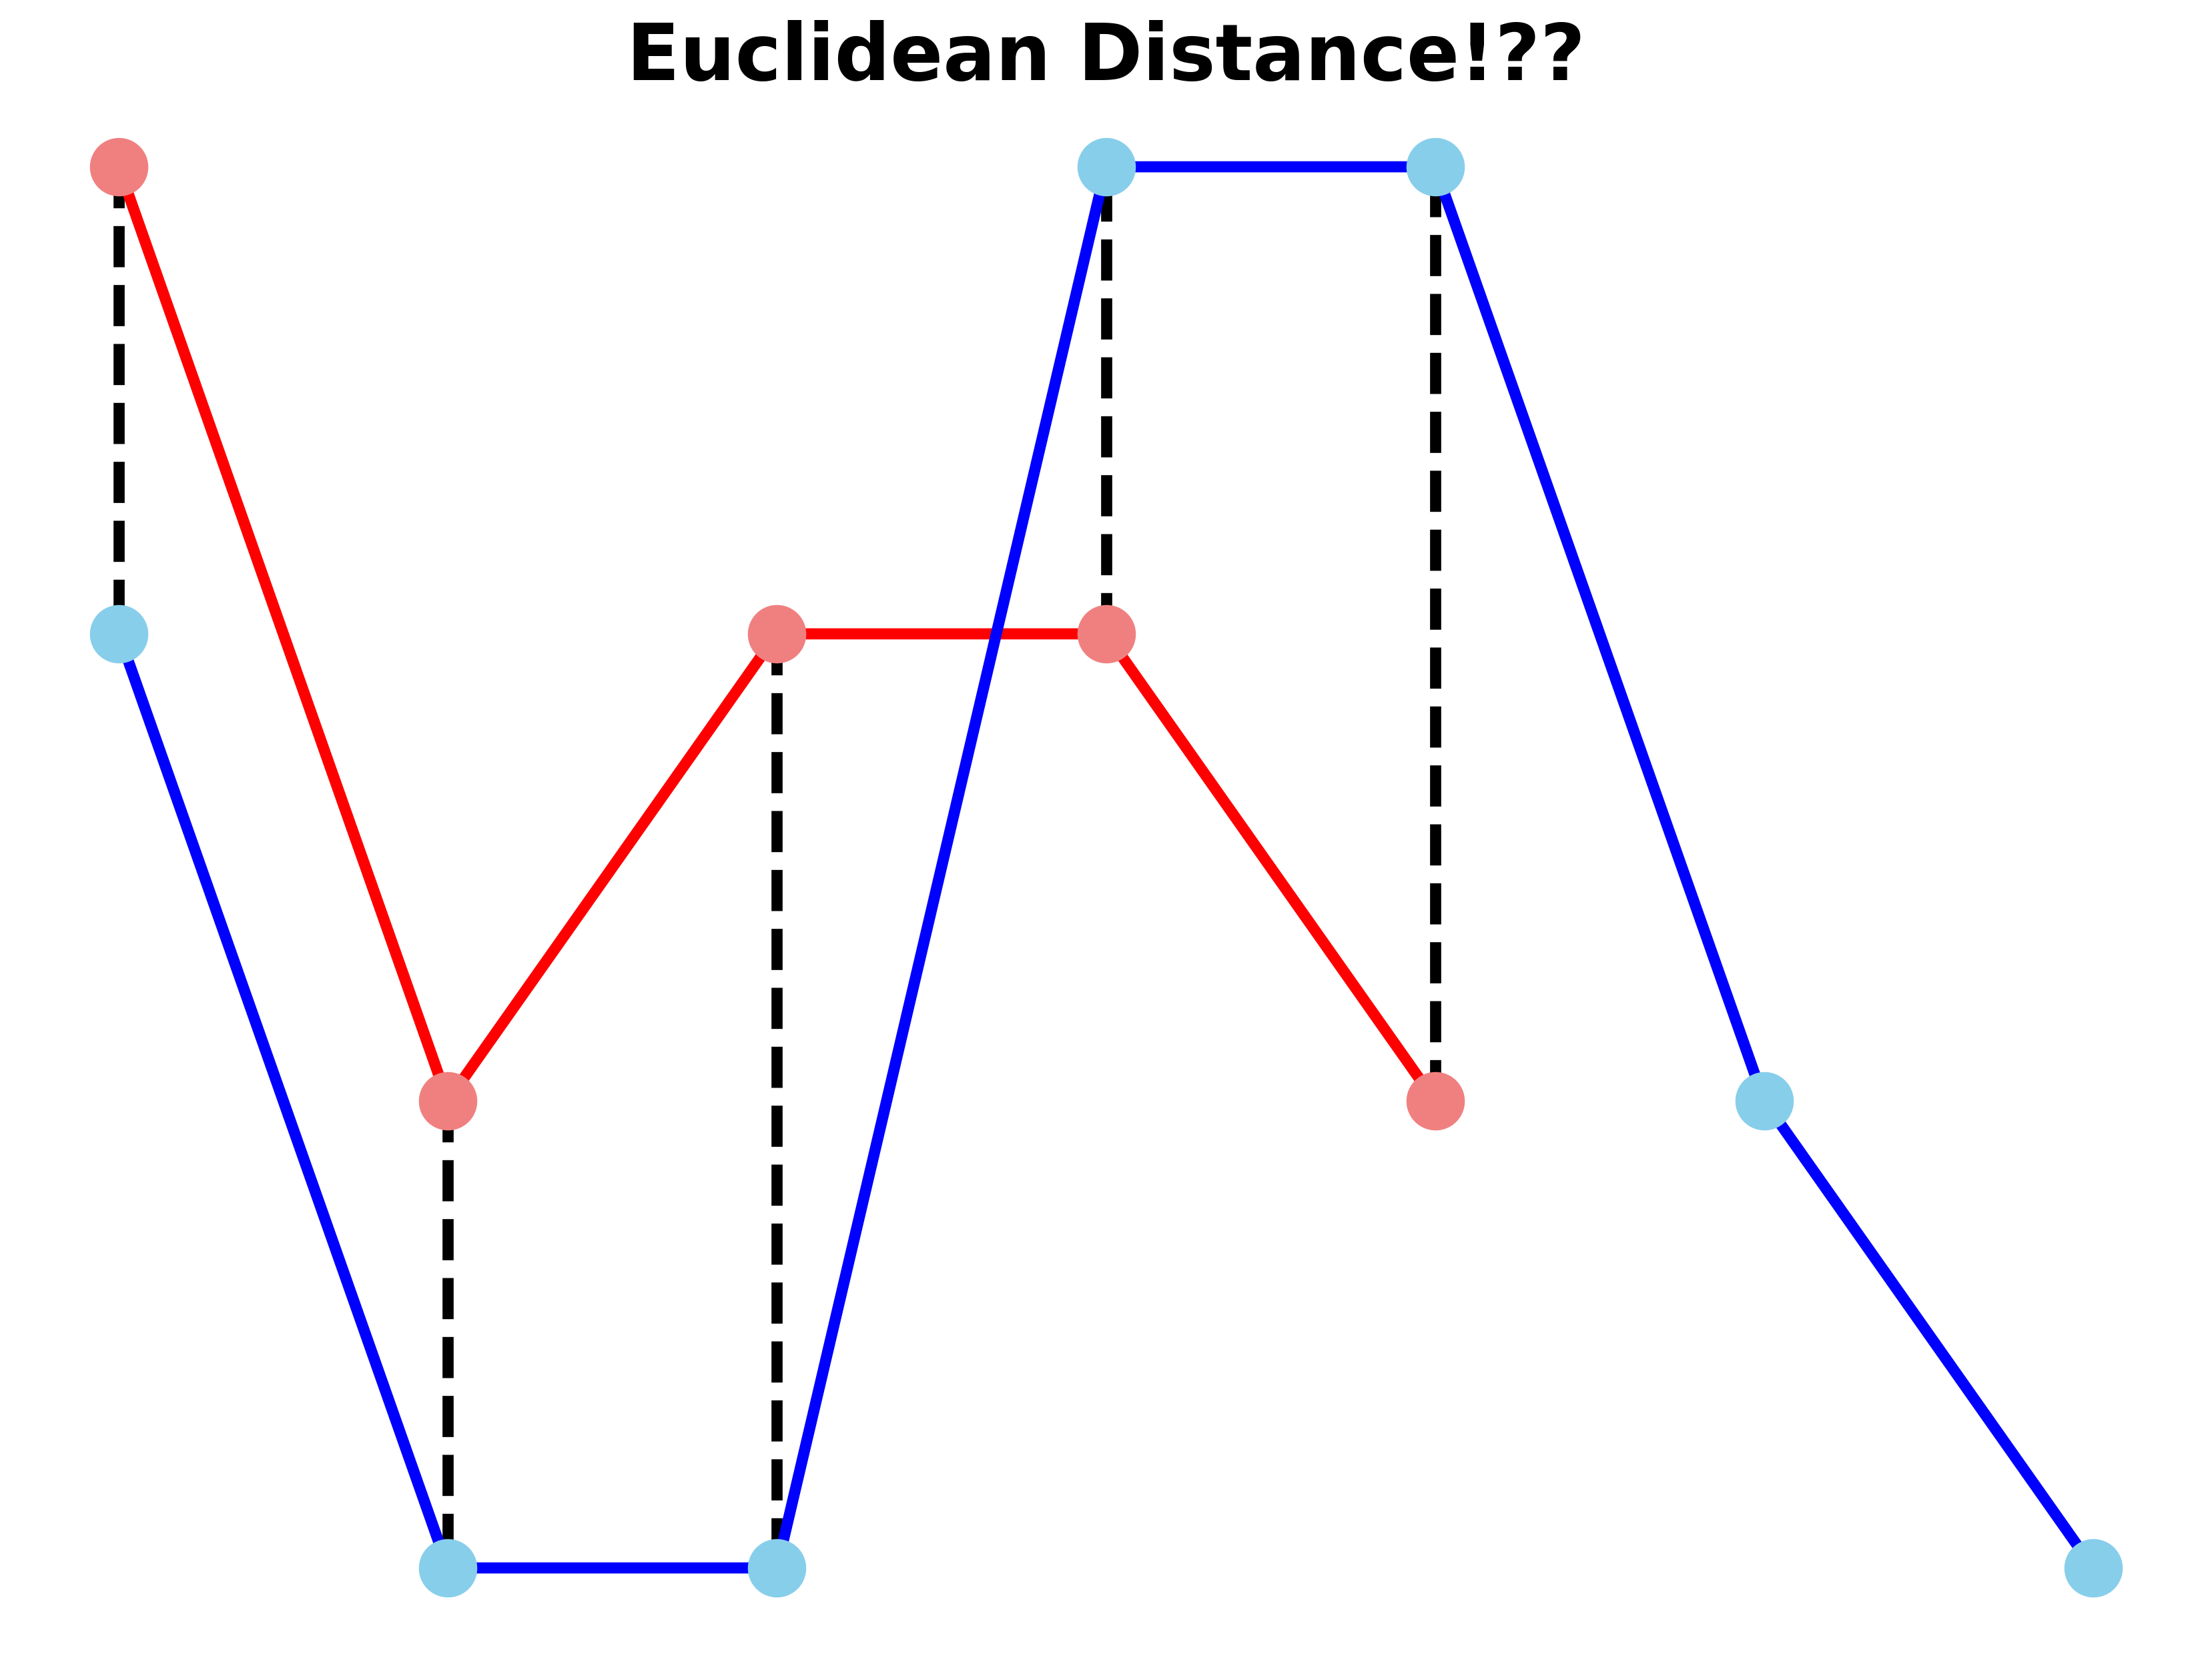

In [6]:
fig, ax = plt.subplots(figsize=(14, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

xx = [(i, x[i]) for i in np.arange(0, len(x))]
yy = [(j, y[j]) for j in np.arange(0, len(y))]

for i, j in zip(xx, yy[:-2]):
    ax.plot([i[0], j[0]], [i[1], j[1]], '--k', linewidth=4)

ax.plot(x, '-ro', label='x', linewidth=4, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=4, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("Euclidean Distance!??", fontsize=28, fontweight="bold")

fig.savefig("ex1_euclidean_distance.png", **savefig_options)

In [7]:
if x.ndim > 1:
    x = np.ravel(x)
if y.ndim > 1:
    y = np.ravel(y)

In [13]:
dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)

In [17]:
cost_matrix = compute_accumulated_cost_matrix(x, y)

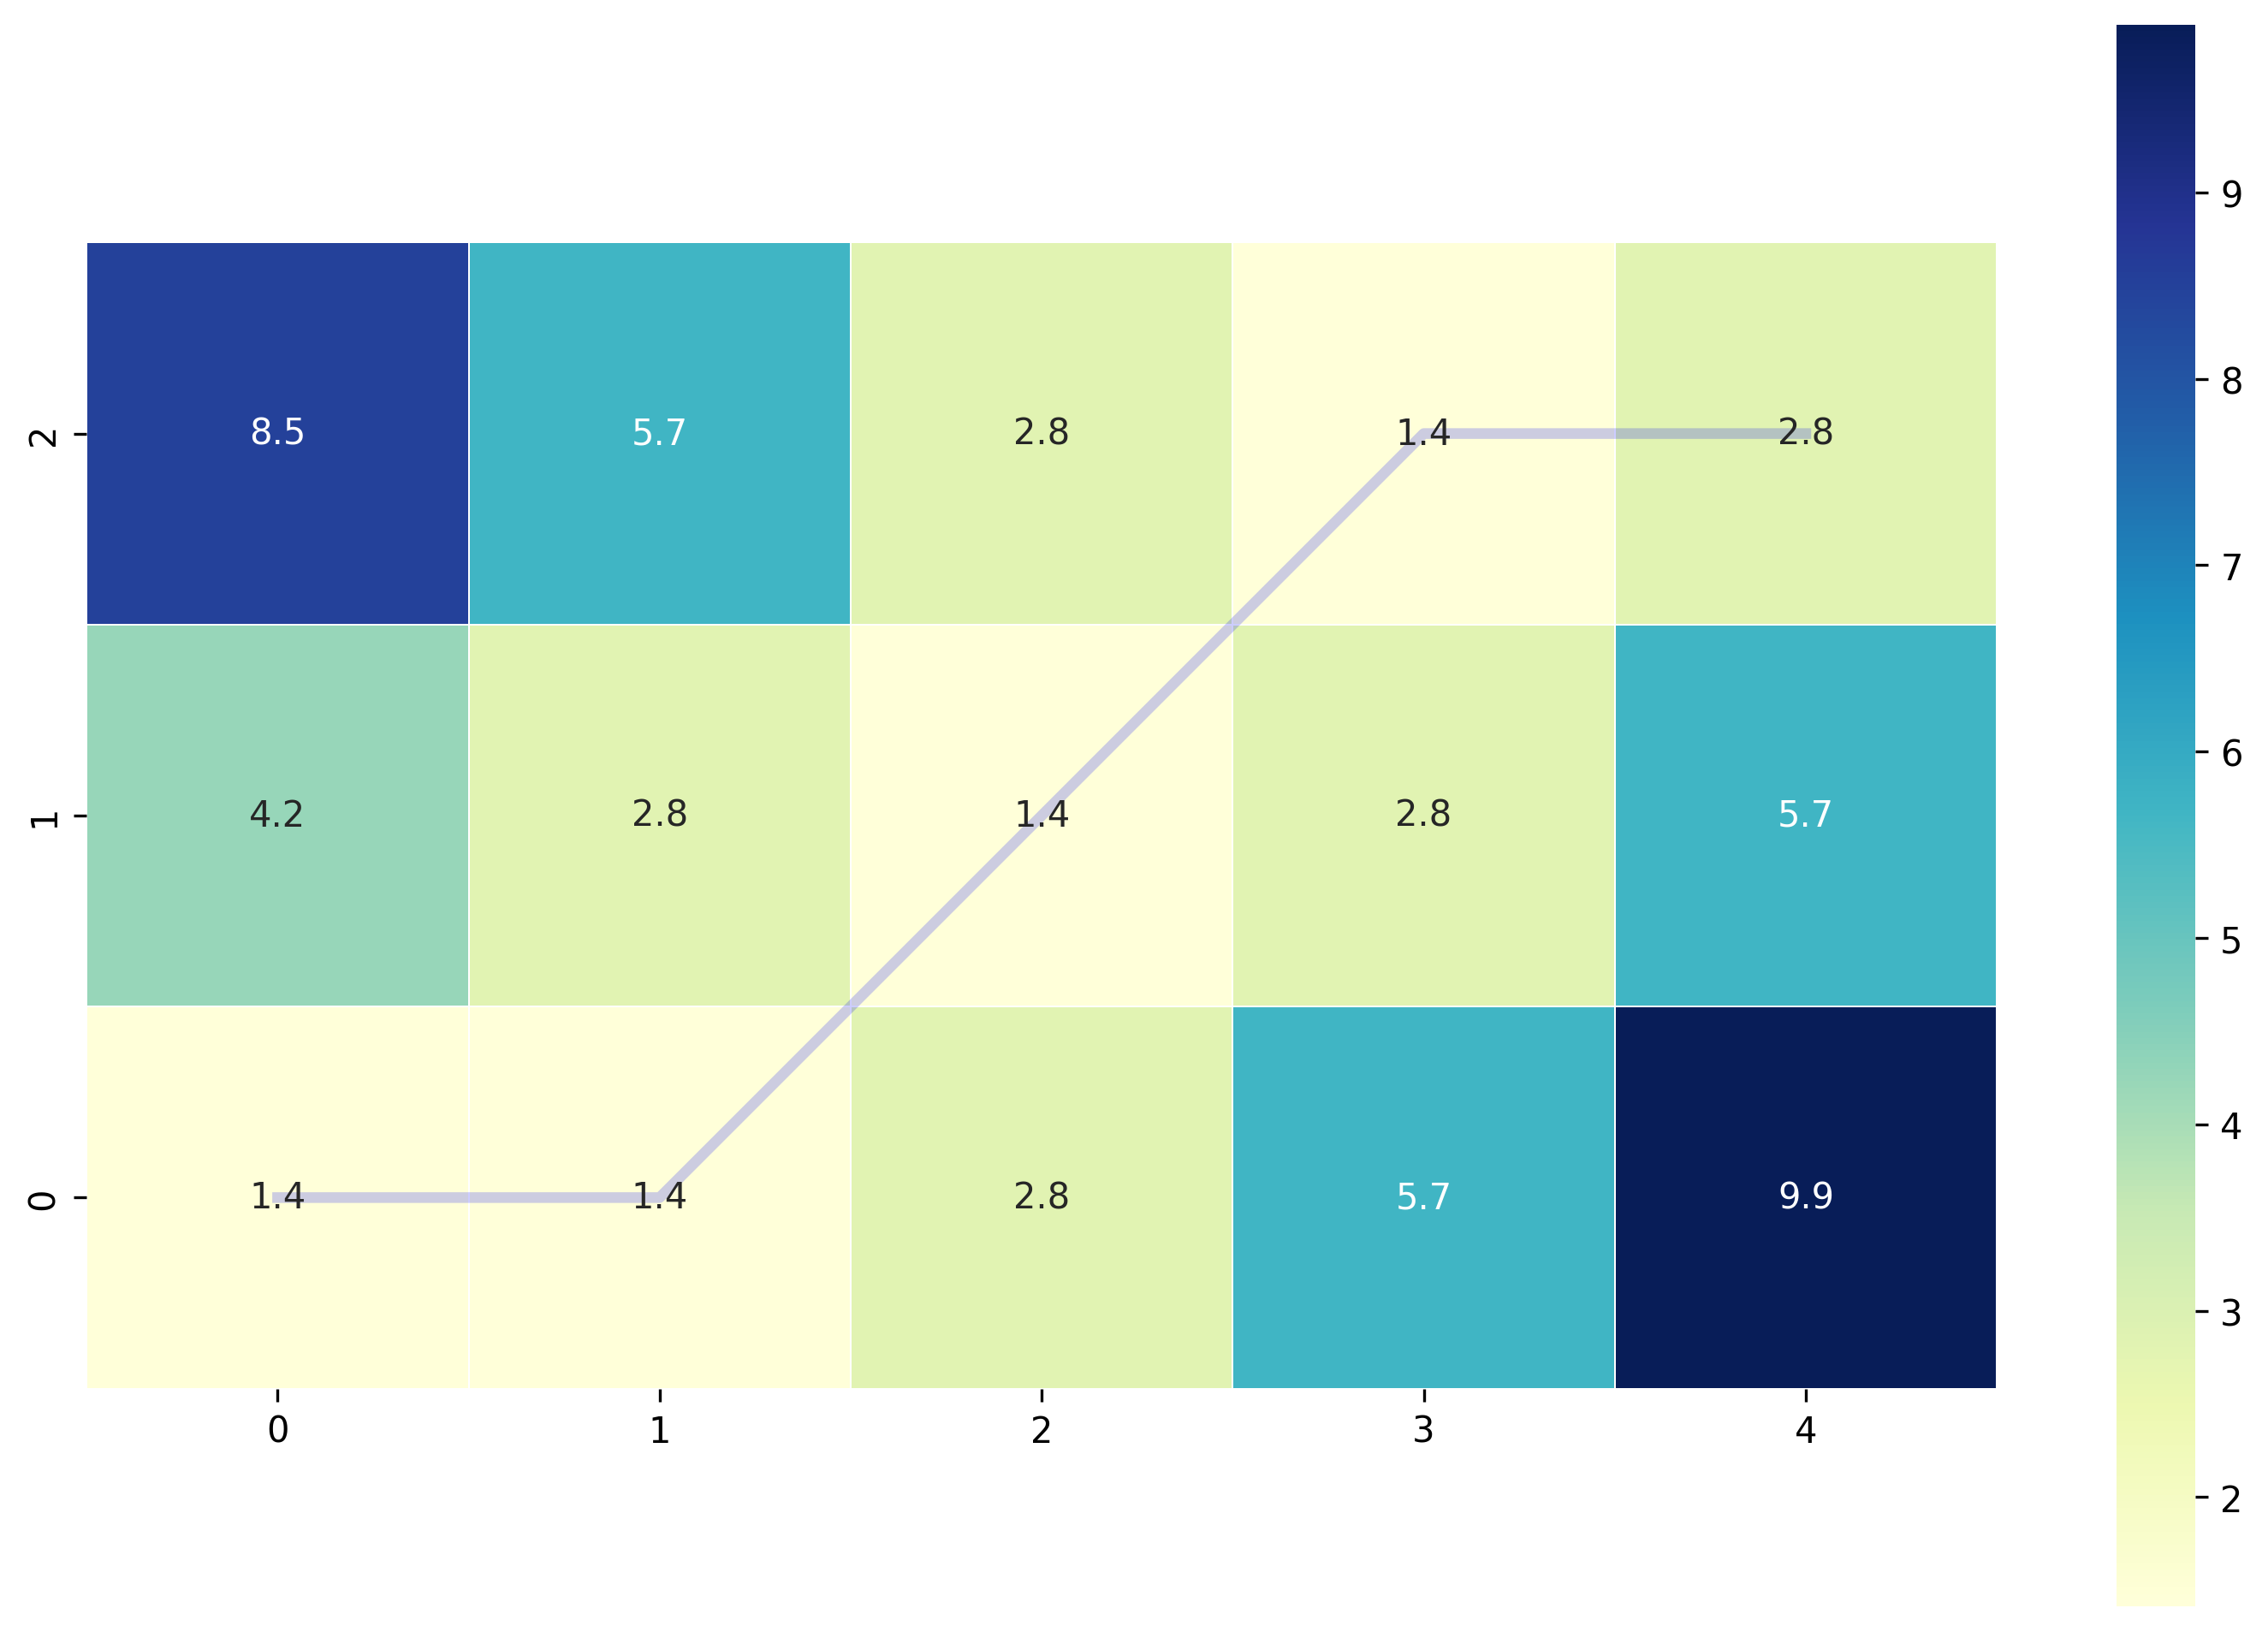

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

fig.savefig("ex1_heatmap.png", **savefig_options)

The color bar shows the cost of each point in the grid. As can be seen, the warp path (blue line) is going through the lowest cost on the grid. Let’s see the DTW distance and the warping path by printing these two variables.

In [19]:
print("DTW distance: ", dtw_distance)
print("Warp path: ", warp_path)

DTW distance:  2.8284271247461903
Warp path:  [(0, 0), (1, 0), (2, 1), (3, 2), (4, 2)]


The warping path starts at point (0, 0) and ends at (4, 6) by 6 moves. Let’s also calculate the accumulated cost most using the functions we defined earlier and compare the values with the heatmap.

In [20]:
cost_matrix = compute_accumulated_cost_matrix(x, y)
print(np.flipud(cost_matrix))

[[8.48528137 5.65685425 2.82842712 1.41421356 2.82842712]
 [4.24264069 2.82842712 1.41421356 2.82842712 5.65685425]
 [1.41421356 1.41421356 2.82842712 5.65685425 9.89949494]]


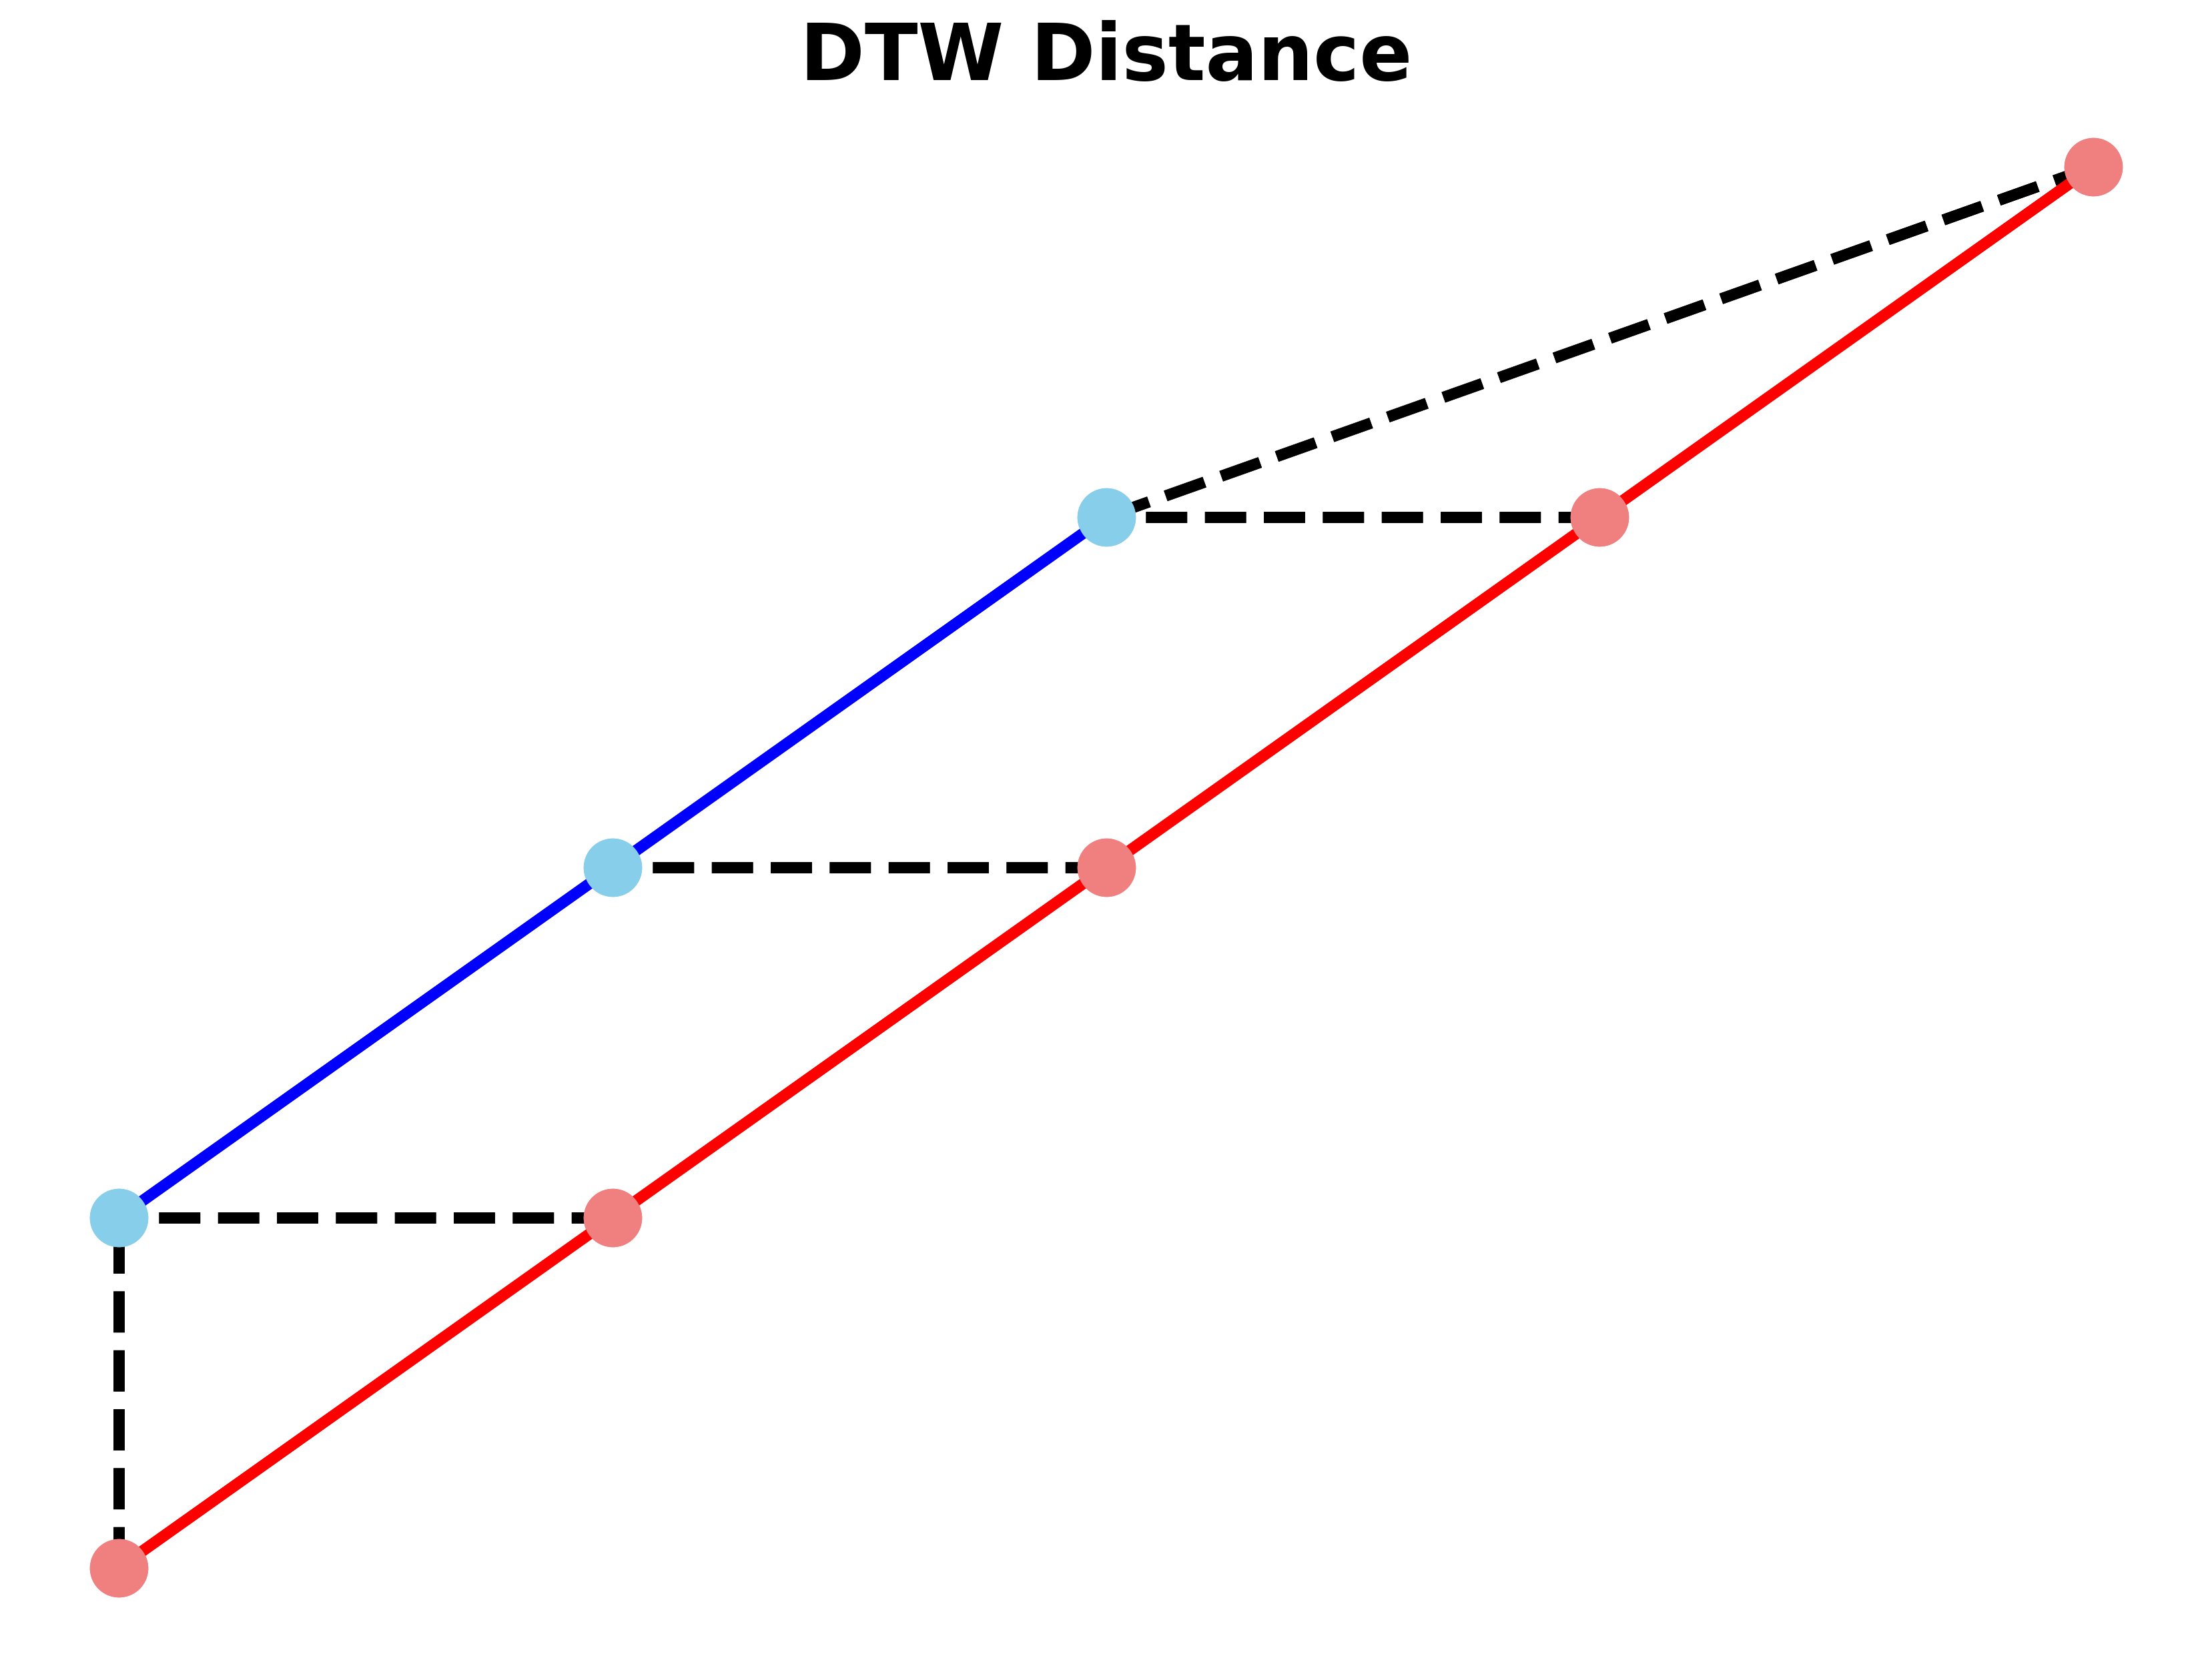

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x[map_x], y[map_y]], '--k', linewidth=4)

ax.plot(x, '-ro', label='x', linewidth=4, markersize=20, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(y, '-bo', label='y', linewidth=4, markersize=20, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("DTW Distance", fontsize=28, fontweight="bold")

fig.savefig("ex1_dtw_distance.png", **savefig_options)

In [24]:
time1 = np.linspace(start=0, stop=1, num=50)
time2 = time1[0:40]

x1 = 3 * np.sin(np.pi * time1) + 1.5 * np.sin(4*np.pi * time1)
x2 = 3 * np.sin(np.pi * time2 + 0.5) + 1.5 * np.sin(4*np.pi * time2 + 0.5)

# Convert x1 and x2 into 2-dimensional format
x1_2d = np.column_stack([x1, np.zeros_like(x1)])
x2_2d = np.column_stack([x2, np.zeros_like(x2)])

In [26]:
distance, path = fastdtw(x1_2d, x2_2d, dist=euclidean)

In [27]:
print("DTW Distance:", distance)
print("Warp Path:", path)

DTW Distance: 17.931248814758465
Warp Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 1), (7, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 10), (10, 11), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 16), (18, 16), (19, 17), (20, 18), (21, 19), (22, 20), (23, 21), (24, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 27), (30, 27), (31, 27), (32, 28), (33, 29), (34, 30), (35, 31), (36, 32), (37, 33), (38, 34), (39, 35), (40, 36), (41, 37), (42, 37), (43, 38), (44, 38), (45, 38), (46, 38), (47, 38), (48, 38), (49, 39)]


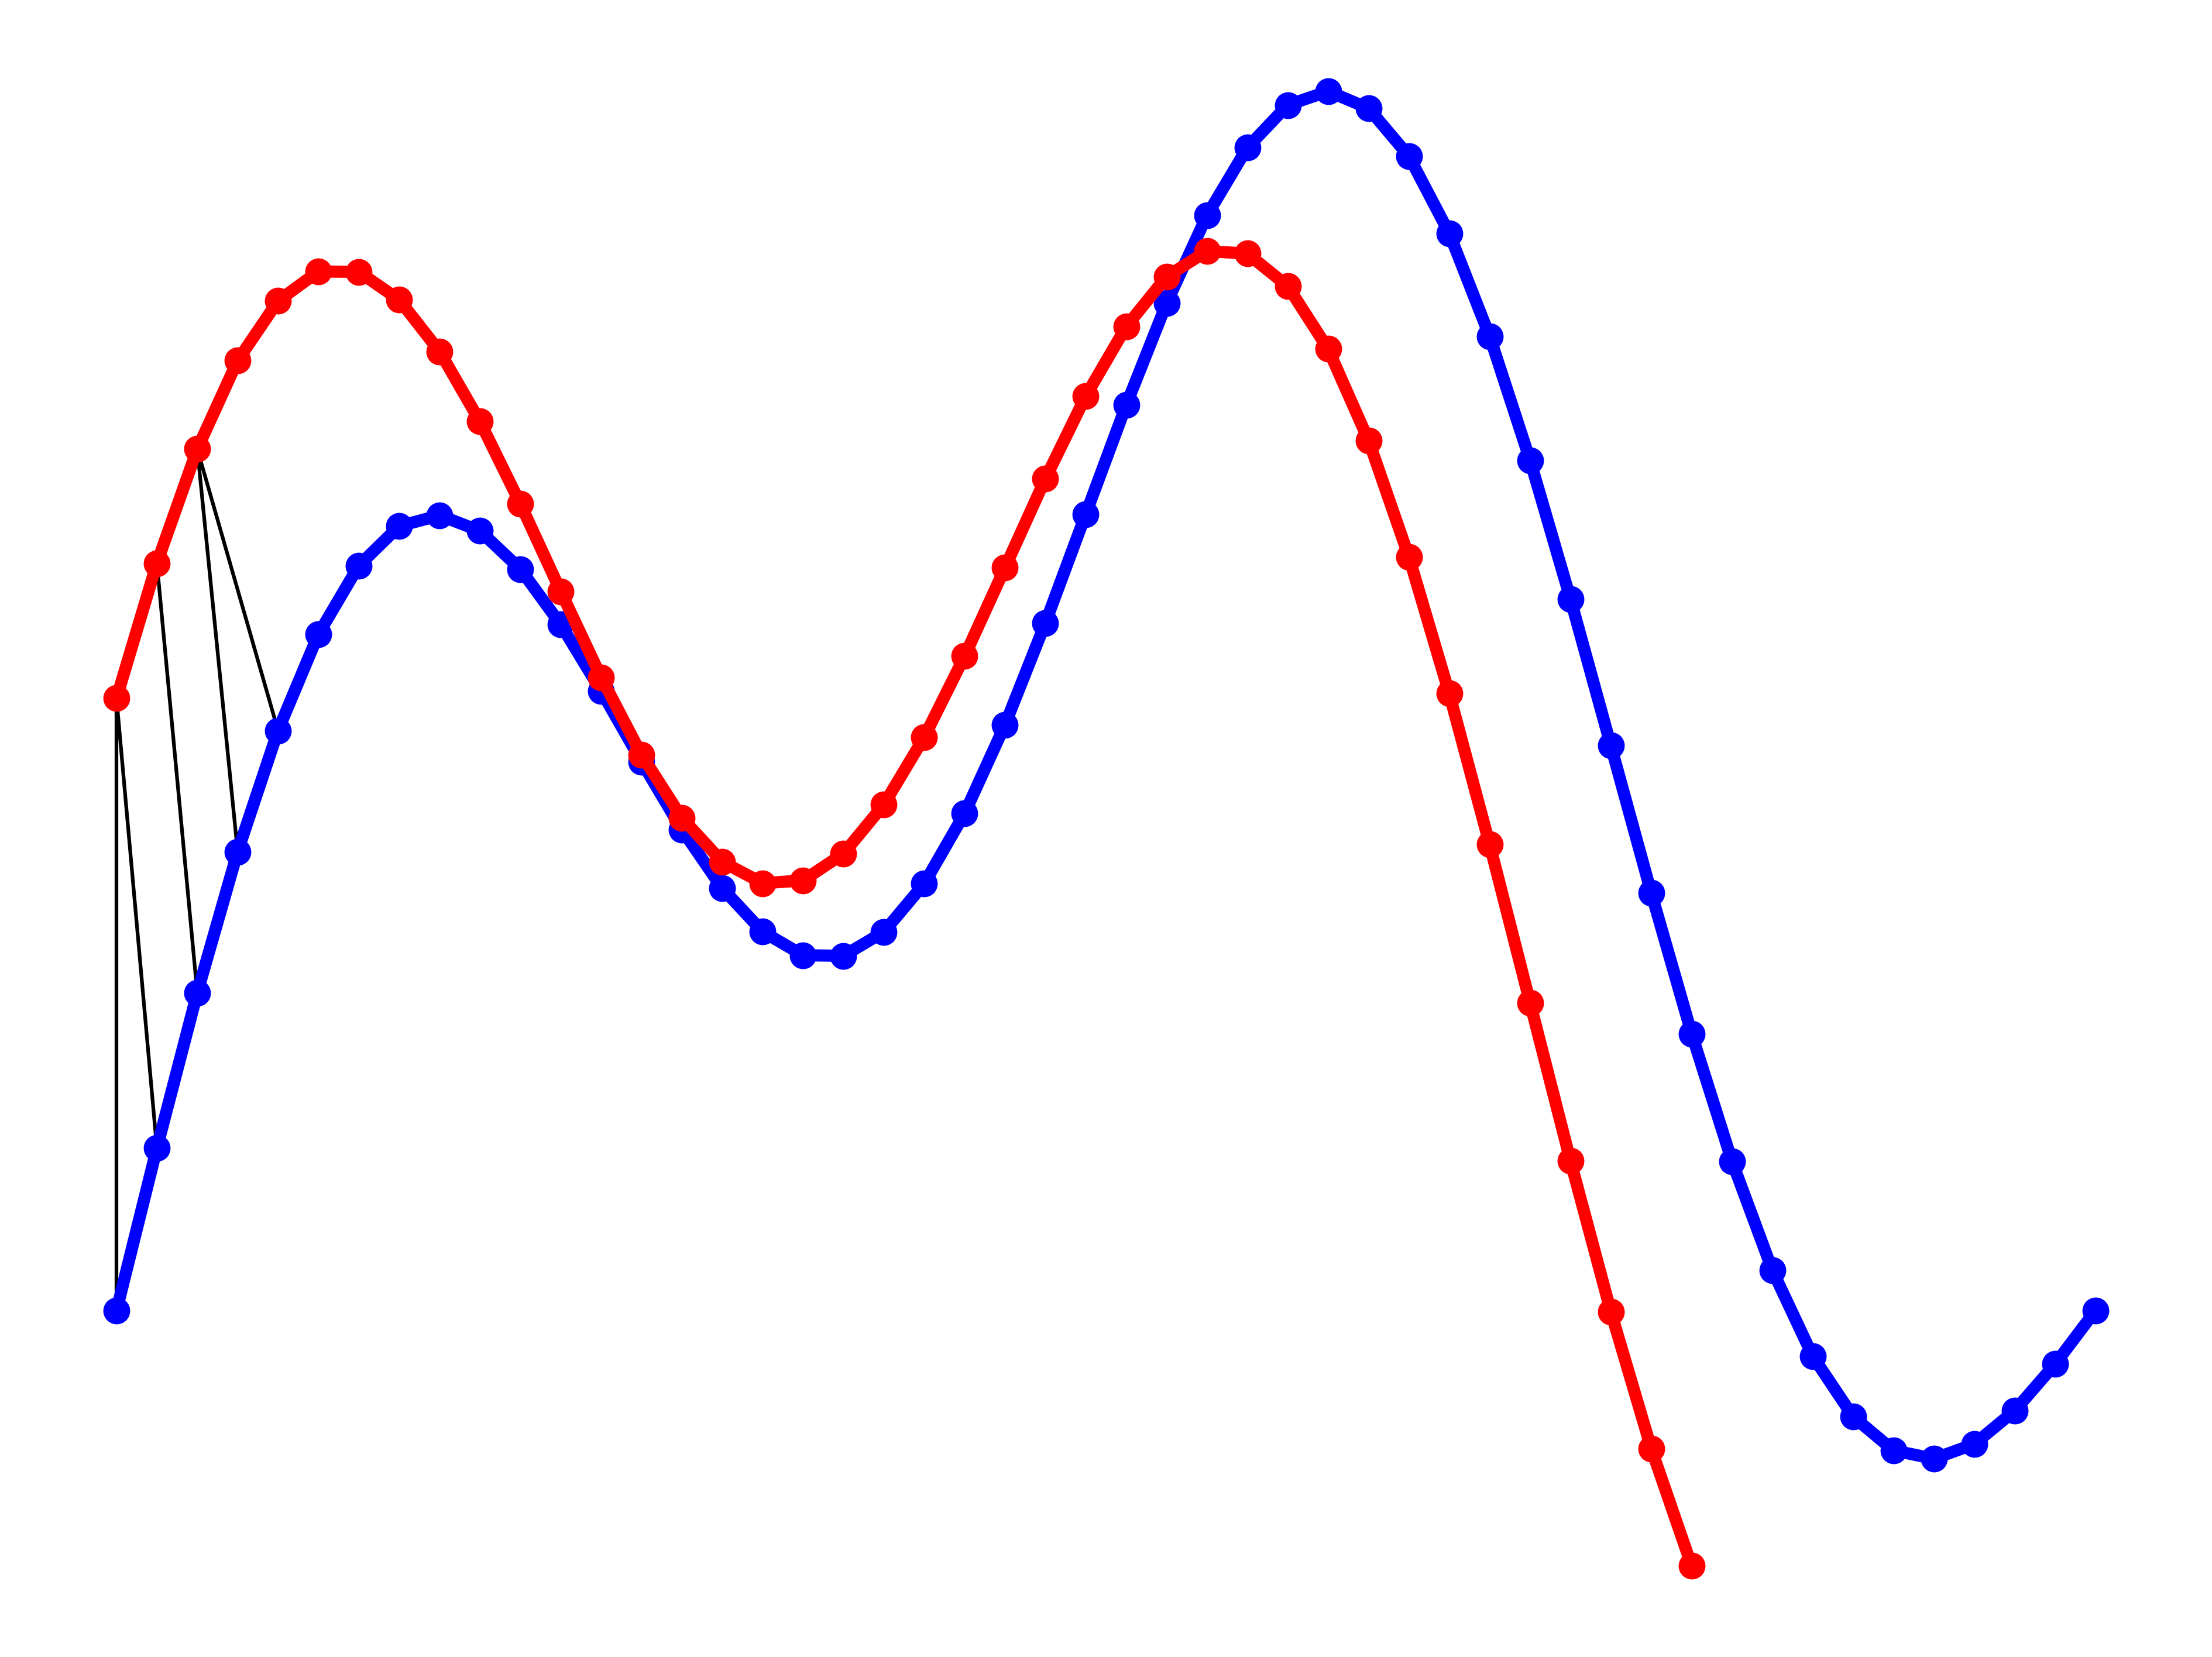

In [28]:
fig, ax = plt.subplots(figsize=(16, 12))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

fig.savefig("ex2_dtw_distance.png", **savefig_options)

As can be seen in above figure, the DTW distance between the two signals is particularly powerful when the signals have similar patterns. The extrema (maximum and minimum points) between the two signals are correctly mapped. Moreover, unlike Euclidean distance, we may see many-to-one mapping when DTW distance is used, particularly if the two signals have different lengths.

You may spot an issue with dynamic time warping from the figure above. Can you guess what it is?

The issue is around the head and tail of time-series that do not properly match. This is because the DTW algorithm cannot afford the warping invariance for at the endpoints. In short, the effect of this is that a small difference at the sequence endpoints will tend to contribute disproportionately to the estimated similarity